In [52]:
## output bikeshare density for what area could support
## output bikeability based on strava data to decide if area is a good idea
## Assumes that bike shares are optimally placed and near optimal capacity
## use regularization in the training of the ML model

import pandas as pd
import pandas_profiling
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import nearest_points
import branca.colormap as cm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
import joblib

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Workaround to fix chrome issue where folium won't plot maps with a large number of layers
# See comment by dstein64 at: https://github.com/python-visualization/folium/issues/812

import base64
def _repr_html_(self, **kwargs):
    html = base64.b64encode(self.render(**kwargs).encode('utf8')).decode('utf8')
    onload = (
        'this.contentDocument.open();'
        'this.contentDocument.write(atob(this.getAttribute(\'data-html\')));'
        'this.contentDocument.close();'
    )
    if self.height is None:
        iframe = (
            '<div style="width:{width};">'
            '<div style="position:relative;width:100%;height:0;padding-bottom:{ratio};">'
            '<iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;'
            'border:none !important;" '
            'data-html={html} onload="{onload}" '
            'allowfullscreen webkitallowfullscreen mozallowfullscreen>'
            '</iframe>'
            '</div></div>').format
        iframe = iframe(html=html, onload=onload, width=self.width, ratio=self.ratio)
    else:
        iframe = ('<iframe src="about:blank" width="{width}" height="{height}"'
                  'style="border:none !important;" '
                  'data-html={html} onload="{onload}" '
                  '"allowfullscreen" "webkitallowfullscreen" "mozallowfullscreen">'
                  '</iframe>').format
        iframe = iframe(html=html, onload=onload, width=self.width, height=self.height)
    return iframe

folium.branca.element.Figure._repr_html_ = _repr_html_


In [3]:
def gridify_polygon(poly,grid_spacing):
    # creates a cartesian grid inside polygon with the input grid_spacing
    # poly: polygon which we want a grid inside
    # grid_spacing: spaceing in lattitude/longitude degrees
    poly_xmin,poly_ymin,poly_xmax,poly_ymax = poly.geometry.total_bounds

    cols = list(np.arange(poly_xmin,poly_xmax+grid_spacing,grid_spacing))
    rows = list(np.arange(poly_ymin,poly_ymax+grid_spacing,grid_spacing))
    rows.reverse()

    polygons = []
    for x in cols:
        for y in rows:
            polygons.append( Polygon([(x,y), (x+grid_spacing, y), (x+grid_spacing, y-grid_spacing), (x, y-grid_spacing)]) )

    grid = gpd.GeoDataFrame({'geometry':polygons})

    grid['isin_poly'] = grid.apply(lambda row: row['geometry'].centroid.within(poly.geometry[0]), axis=1)
    poly_grid = grid[grid.isin_poly == True]
    poly_grid.crs = {'init': 'epsg:4326', 'no_defs': True}
    poly_grid = poly_grid.drop(['isin_poly'], axis = 1)
    
    # Calculate the polygon areas in km
    poly_grid_cart = poly_grid.copy()
    poly_grid_cart = poly_grid_cart.to_crs({'init': 'epsg:3857'})
    poly_grid_cart['poly_area_km'] = poly_grid_cart['geometry'].area/ 10**6
    # Store polygon area
    poly_grid['poly_area_km'] = poly_grid_cart['poly_area_km']
    
    # 
    poly_grid = poly_grid.reset_index()
    return poly_grid

def amenity_in_polygon(amenity_points,poly):
    # returns the amenities that are inside the given polygon
    # When there are zero amenities within the interrogation region, the function returns an empty dataframe as
    # as expected, but also prints out a lot of errors. not a huge issue but annoying.
    # Maybe implement a test for if empty, return 0
    # Example use:
    #         amenity_in_polygon(food_amenities,city_grid.geometry.iloc[38])
    
    # Generate boolean list of whether amenity is in polygon
    indices = amenity_points.apply(lambda row: row['geometry'].within(poly), axis=1)
    if not any(indices): # If all indices are false
        return pd.DataFrame(columns=['A']) # return empty dataframe (not sure what is best to output here )
    else:
        return amenity_points[amenity_points.apply(lambda row: row['geometry'].within(poly), axis=1)]

def avg_dist_to_amenities(interrogation_point,amenity_df,n):
    # calculates the mean distance of the n nearest amenities to the interrogation point
    # If there are less than n amenities in the search it'll just return the average of the known amenities.
    # Example: avg_dist_to_amenities(city_grid.geometry.iloc[39],food_amenities,5)
    dist_to_amenity = amenity_df['geometry'].apply(lambda x: x.distance(interrogation_point))
    dist_to_amenity.sort_values(inplace=True)
    dist_to_amenity[:5]
    if len(dist_to_amenity) >= n:
        return dist_to_amenity[:n].mean()
    elif len(dist_to_amenity) == 0:
        return np.nan
    else:
        return dist_to_amenity.mean()
    
    
# Generate features dataframe by finding the count of each unique amenity in each region
def features_density(interrogation_grid,osm_features,targets):
    # Calculate feature and target density inside a series of polygons
    # INPUTS
    # ------
    # Interrogation grid: list of polygons in which to calculate density of features and targets
    # osm_features: gdf of amenities in area retrieved from OSM
    # targest: gdf of target locations
    # OUTPUTS
    # -------
    # cleaned_df: contains the density of features and targets in the interrogation grid
    # create new cleaned df that will store features and target data
    cleaned_df = interrogation_grid.copy()
    cleaned_df = cleaned_df.reset_index()
    cleaned_df['bike_rental_density'] = 0
    cleaned_df = cleaned_df.reindex(cleaned_df.columns.tolist() + amenity_names, axis=1) 


    # loop through grid points and populate features.
    for index, row in cleaned_df.iterrows():
        grid_pt = cleaned_df.geometry.iloc[index]
        amenities_in_grid = amenity_in_polygon(osm_features,grid_pt)

        # fill amenity rows with counts inside each polygon
        if len(amenities_in_grid) > 0:
            amenity_counts = amenities_in_grid['amenity'].value_counts()
            for val, cnt in amenity_counts.iteritems():
                # test if value is in list of features that are selected for ML model
                if val in amenity_names:
                    cleaned_df[val].iloc[index] = cnt / cleaned_df.poly_area_km.iloc[index]

        # add target column for bike rentals
        bike_rentals_in_grid = amenity_in_polygon(targets,grid_pt)
        if len(bike_rentals_in_grid) > 0:
            cleaned_df['bike_rental_density'].iloc[index] = len(bike_rentals_in_grid) / cleaned_df.poly_area_km.iloc[index]
        else:
            cleaned_df['bike_rental_density'].iloc[index] = 0

    # remove nan values
    cleaned_df[amenity_names] = cleaned_df[amenity_names].fillna(0)
    # remove unecessary columns
    cleaned_df = cleaned_df.drop(columns = ['level_0','index'])
    # relable as density 
    new_names = [name + '_density' for name in amenity_names]
    cleaned_df.rename(columns = dict(zip(amenity_names, new_names)), inplace=True)
    
    return cleaned_df

In [4]:
folder_name = 'OSM_geo_data/'
city_names = ['austin','berkeley','boston','chicago','denver','glasgow','los_angeles',
              'minneapolis','montreal','new_york','san_francisco','salt_lake_city','phoenix',
             'columbus','paris','munich','brussels']


# Initialize dataframes
df = pd.DataFrame()
city_grid = pd.DataFrame()

# Combine data from different cities
for name in city_names:
    filename_cleaned_df = folder_name + name + '_feature_target_table.geojson'
    filename_grid = folder_name + name + '_grid.geojson'
    if df.empty:
        df = gpd.read_file(filename_cleaned_df)
        city_grid = gpd.read_file(filename_grid)
    else:
        df = df.append(gpd.read_file(filename_cleaned_df), ignore_index=True)





In [5]:
# Define feature and target labels
features = ['pharmacy_density', 'recycling_density', 'place_of_worship_density', 'post_box_density',
            'library_density', 'post_office_density', 'parking_density', 'fuel_density', 'bank_density',
            'pub_density', 'telephone_density', 'toilets_density', 'taxi_density', 'bicycle_parking_density',
            'motorcycle_parking_density', 'fast_food_density', 'bar_density', 'life_boats_density',
            'restaurant_density', 'arts_centre_density', 'music_venue_density', 'nightclub_density',
            'cafe_density', 'atm_density', 'community_centre_density', 'jobcentre_density', 'doctors_density',
            'cinema_density', 'grave_yard_density', 'police_density', 'bus_station_density', 'theatre_density',
            'bureau_de_change_density', 'hospital_density', 'bench_density', 'school_density', 'courthouse_density',
            'ice_cream_density', 'fountain_density', 'left_luggage_density', 'drinking_water_density',
            'casino_density', 'car_rental_density', 'car_wash_density', 'ferry_terminal_density', 'dentist_density',
            'townhall_density', 'shelter_density', 'parking_entrance_density', 'conference_centre_density',
            'marketplace_density', 'vending_machine_density', 'waste_basket_density', 'clock_density',
            'studio_density', 'veterinary_density', 'gallery_density', 'gambling_density', 'kindergarten_density',
            'social_facility_density', 'charging_station_density', 'car_sharing_density', 'clinic_density',
            'water_density', 'compressed_air_density', 'public_building_density', 'social_centre_density',
            'childcare_density', 'grit_bin_density', 'bicycle_repair_station_density', 'events_venue_density',
            'embassy_density', 'college_density', 'circus_school_density', 'parcel_lockers_density',
            'money_transfer_density', 'photo_booth_density', 'luggage_locker_density', 'university_density',
            'venue_density', 'swimming_pool_density', 'fire_station_density', 'post_depot_density',
            'crematorium_density', 'sport_density', 'nursing_home_density', 'biergarten_density', 'garden_density',
            'prison_density', 'club_density', 'parking_space_density', 'trailer_park_density', 'archive_density',
            'monastery_density']
target = ['bike_rental_density']

In [6]:
## Remove features that are very sparse

# Get percentage of non-zero values for target variable
pcent_target_positive = df[target].astype(bool).sum(axis=0)/len(df)
# print(pcent_target_positive)
# Get percentage of non zero values for each feature
pcent_non_zero_features = df[features].astype(bool).sum(axis=0)/len(df)

# print(pcent_non_zero_features)
zero_pcent_threshold = 0.01
relevant_features = pcent_non_zero_features.index[pcent_non_zero_features>zero_pcent_threshold].tolist()



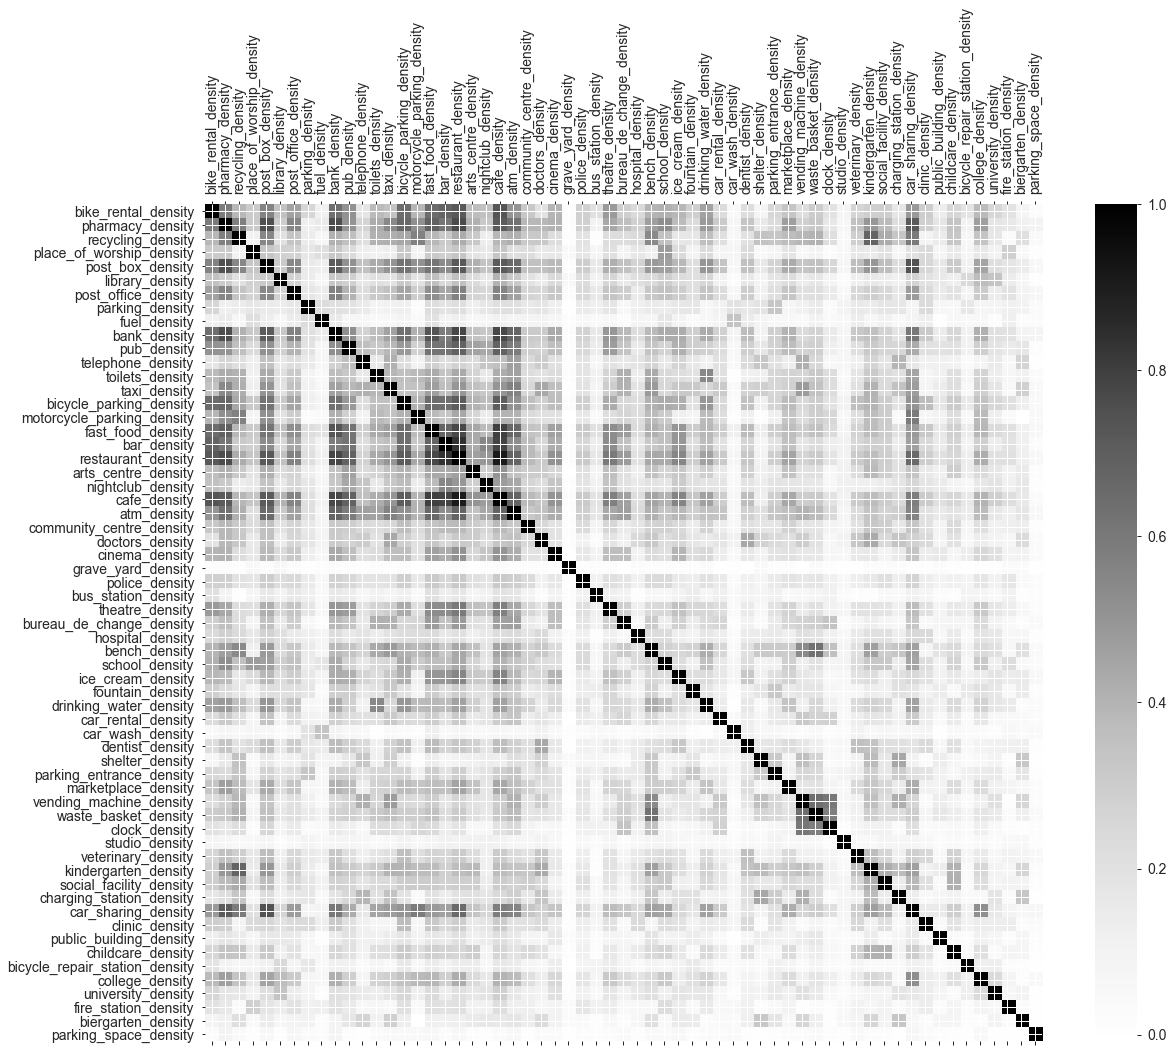

In [7]:
## Show correlation between input features
corr_df = df[target + relevant_features].corr()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr_df, fignum=f.number)
plt.xticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14, rotation=90)
plt.yticks(range(corr_df.shape[1]), corr_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);

In [9]:
# Get features that are most correlated to predictions of bike share density
corr_threshold = 0.2
feature_relevance = (corr_df.bike_rental_density).sort_values(ascending=False)
feature_relevance
top_features = list(feature_relevance[feature_relevance > corr_threshold].index)
# make sure to remove bike_rentals from training data 
top_features.remove('bike_rental_density')
# remove features that are strongly correlated to others
top_features.remove('post_box_density') # correlated to car shares
top_features.remove('restaurant_density') # correlated to cafes

# remove features that are highly correlated to each other, e.g. cafes and restaurants.
print(top_features)
print('Number of features reduced to %2.0f from %2.0f' % (len(top_features), len(features)))

['cafe_density', 'bar_density', 'bicycle_parking_density', 'fast_food_density', 'bank_density', 'pharmacy_density', 'pub_density', 'atm_density', 'car_sharing_density', 'theatre_density', 'post_office_density', 'drinking_water_density', 'school_density', 'cinema_density', 'bench_density', 'motorcycle_parking_density', 'ice_cream_density', 'recycling_density', 'college_density', 'toilets_density', 'arts_centre_density', 'nightclub_density', 'library_density', 'taxi_density', 'marketplace_density', 'community_centre_density', 'place_of_worship_density', 'waste_basket_density', 'clinic_density', 'social_facility_density', 'fountain_density', 'bureau_de_change_density', 'kindergarten_density', 'police_density', 'veterinary_density', 'parking_density', 'university_density', 'parking_entrance_density', 'childcare_density', 'hospital_density', 'car_rental_density', 'vending_machine_density', 'dentist_density', 'bus_station_density']
Number of features reduced to 44 from 94


In [10]:
# Profile features collected from OSM and check for correlation
# feature_profile = pandas_profiling.ProfileReport(df[target + features])
# feature_profile.to_file(output_file='osm_bike_share_feature_profile.html')


956 7991 0.1196345889125266
Linear regression is not the best option given that the target is highly skewed towards 0


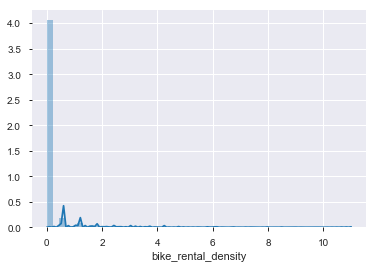

In [11]:
# Split data into train and test
X = df[top_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pos_target = len(y[y.bike_rental_density != 0])
neg_target = len(y[y.bike_rental_density == 0])
print(pos_target,neg_target,pos_target/neg_target)

sns.distplot(y.bike_rental_density);
print('Linear regression is not the best option given that the target is highly skewed towards 0')

In [12]:
## Linear model
LM_model = LinearRegression()
LM_model.fit(X_train,y_train)
LM_y_pred = LM_model.predict(X_test)

## Lasso
lasso_rmse = []
ridge_rmse = []
EN_rmse = []
alpha_ref = np.linspace(0.001,1,101)

for ind, alpha in enumerate(alpha_ref):
    
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train,y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    
    ridge_model = Ridge(alpha = alpha)
    ridge_model.fit(X_train,y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))
    
    EN_model = ElasticNet(alpha = alpha)
    EN_model.fit(X_train,y_train)
    EN_y_pred = EN_model.predict(X_test)
    EN_rmse.append(metrics.mean_absolute_error(y_test,lasso_y_pred))


## Random Forest
# RF_model = RandomForestRegressor(random_state = 2,max_depth = 9,max_leaf_nodes = 67)
RF_model = RandomForestRegressor()
RF_model.fit(X_train,y_train)
RF_y_pred = RF_model.predict(X_test)



/Users/peter/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [ ]:
## Display linear coefficients to see which features are most correlated to bike share density
# linear_coeffs = pd.DataFrame({'feature_name': top_features, 'Coefficient': LM_model.coef_.flatten()})
# linear_coeffs.sort_values(by='Coefficient', ascending=False)

# Random Forest Tuning

In [41]:
## Define random grid for tuning random forest parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [43]:
## Use the random grid to search for best RF hyperparameters
# Takes a long time, only run if you have time

# First create the base model to tune
rf2 = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 62.1min finished
/Users/peter/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

In [49]:
## Predict bike shares using the best RF 
best_random = rf_random.best_estimator_
RF_rand_y_pred = best_random.predict(X_test)


In [53]:
# Save best RF model
# save the model to disk
filename = 'best_RF_model.sav'
joblib.dump(best_random, filename)

['best_RF_model.sav']

# Cross Validation on hold out set

In [50]:
## Linear regression isn't the best option given that the target is highly skewed towards 0

print('Multivariate linear regression mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,LM_y_pred))
print('Lasso mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(lasso_rmse),alpha_ref[np.argmin(lasso_rmse)]))
print('Ridge mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(ridge_rmse),alpha_ref[np.argmin(ridge_rmse)]))
print('Elastic Net mean absolute error (MAE): %4.3f and alpha = %4.3f' % (min(EN_rmse),alpha_ref[np.argmin(EN_rmse)]))

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,RF_y_pred))
print('Best Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(y_test,RF_rand_y_pred))







Multivariate linear regression mean absolute error (MAE): 0.179
Lasso mean absolute error (MAE): 0.169 and alpha = 0.021
Ridge mean absolute error (MAE): 0.169 and alpha = 0.021
Elastic Net mean absolute error (MAE): 0.169 and alpha = 0.021
Random forest mean absolute error (MAE): 0.147
Best Random forest mean absolute error (MAE): 0.137


# Independent model prediction on Portland

Portland is not included in the training set and this is used for independent validation

In [16]:
## Start validation on unseen city, 
place = 'Portland, Oregon, USA'

# city_grid = gpd.read_file(filename_grid)
# all_amenities = gpd.read_file(filename_amenities)
# bike_rentals = gpd.read_file(filename_bike_rentals)

# Generate city grid for interrogation
city = ox.gdf_from_place(place)
portland_grid = gpd.read_file(folder_name + 'portland_grid.geojson')
portland_ft = gpd.read_file(folder_name + 'portland_feature_target_table.geojson')
portland_bike_rentals = gpd.read_file(folder_name + 'portland_bike_rentals.geojson')

In [35]:
portland_predict = RF_model.predict(portland_ft[top_features])
portland_comparison = portland_grid.copy()
portland_comparison['bike_rental_density'] = portland_ft['bike_rental_density'] 
portland_comparison['RF_prediction'] = portland_predict
portland_comparison['bike_rental_diff'] = portland_comparison['RF_prediction'] - portland_comparison['bike_rental_density']
# tes
portland_comparison

scale_factor = max(max(portland_predict),max(portland_comparison.bike_rental_density))

portland_comparison['scaled_actual_density'] = portland_ft['bike_rental_density'] / scale_factor
portland_comparison['scaled_pred_density'] = portland_comparison['RF_prediction'] / scale_factor

print('Random forest mean absolute error (MAE): %4.3f' % metrics.mean_absolute_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction))
print('Random forest mean squared error (MSE): %4.3f' % metrics.mean_squared_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction))
print('Random forest root mean squared error (RMSE): %4.3f' % np.sqrt(metrics.mean_squared_error(portland_comparison.bike_rental_density,portland_comparison.RF_prediction)))


# RMSE is low because most of the grid cells are empty and random forest captures that well. Does this misrepresent the accuracty?
# Results could be improved with bike friendliness score

Random forest mean absolute error (MAE): 0.186
Random forest mean squared error (MSE): 0.239
Random forest root mean squared error (RMSE): 0.489


In [21]:
# define dictionaries for opacity and colormaps
pred_dict = portland_comparison['scaled_pred_density']
actual_dict = portland_comparison['scaled_actual_density']
diff_dict = portland_comparison['bike_rental_diff']

pred_opacity = {str(key): pred_dict[key] for key in pred_dict.keys()}
actual_opacity = {str(key): actual_dict[key] for key in actual_dict.keys()}
diff_opacity = {str(key): abs(diff_dict[key]) for key in diff_dict.keys()}

colormap = cm.linear.RdBu_11.scale(-scale_factor,scale_factor)
# colormap = cm.LinearColormap(colors=['yellow','white','green'],vmin=0,vmax=scale_factor)

diff_color = {str(key): colormap(diff_dict[key]) for key in diff_dict.keys()}
colormap

In [22]:
m = folium.Map([city.geometry.centroid.y, city.geometry.centroid.x],
               zoom_start=11,
               tiles="CartoDb positron")

style_city = {'color':'#ebc923 ', 'fillColor': '#ebc923 ', 'weight':'1', 'fillOpacity' : 0.1}
folium.GeoJson(city,
               style_function=lambda x: style_city,
               name='City Limit').add_to(m)

# Plot actual bike share density
folium.GeoJson(
    portland_comparison['geometry'],
    name='Actual bike share density',
    style_function=lambda feature: {
        'fillColor': '#0675c4',
        'color': 'black',
        'weight': 0,
        'fillOpacity': actual_opacity[feature['id']],
    }
).add_to(m)

# plot predictions of bike share density
folium.GeoJson(
    portland_comparison['geometry'],
    name='Prediction: bike share density',
    style_function=lambda feature: {
        'fillColor': '#0675c4',
        'color': 'black',
        'weight': 0,
        'fillOpacity': pred_opacity[feature['id']],
    }
).add_to(m)

# plot difference between predicted and actual
# folium.GeoJson(
#     portland_comparison['geometry'],
#     name='Difference: bike share density',
#     style_function=lambda feature: {
#         'fillColor': '#1FFD09',
#         'color': 'black',
#         'weight': 0,
#         'fillOpacity': diff_opacity[feature['id']],
#     }
# ).add_to(m)

folium.GeoJson(
    portland_comparison['geometry'],
    name='Difference: bike share density',
    style_function=lambda feature: {
        'fillColor': diff_color[feature['id']],
        'color': 'black',
        'weight': 0,
#         'fillOpacity': 0.5,
        'fillOpacity': diff_opacity[feature['id']],
    }
).add_to(m)

colormap.caption = 'Difference in bike density prediction'
colormap.add_to(m)


folium.LayerControl().add_to(m)

# m.save("portland_validation.html")
m

In [ ]:
## Tried to put into categories and compute confusion matrix but prediction is of bike share demand and not categories

# positives = portland_comparison[(portland_comparison.bike_rental_density != 0)]
# negatives = portland_comparison[(portland_comparison.bike_rental_density == 0)]
# pos_count = len(positives)
# neg_count = len(negatives)

# print('Positives %2.0f, Negatives %2.0f, Total %2.0f' % (pos_count,neg_count,len(portland_comparison)))

# density_threshold = 0
# true_pos = portland_comparison[(portland_comparison.bike_rental_density != 0) & (portland_comparison.bike_rental_diff > density_threshold)]
# false_pos = portland_comparison[(portland_comparison.bike_rental_density == 0) & (portland_comparison.bike_rental_diff > density_threshold)]
# true_neg = portland_comparison[(portland_comparison.bike_rental_density == 0) & (portland_comparison.bike_rental_diff < density_threshold)]
# false_neg = portland_comparison[(portland_comparison.bike_rental_density != 0) & (portland_comparison.bike_rental_diff < density_threshold)]

# TP_count = len(true_pos)
# FP_count = len(false_pos)
# TN_count = len(true_neg)
# FN_count = len(false_neg)

# print('True positives %2.0f, False positives %2.0f' % (TP_count,FP_count))
# print('True negatives %2.0f, False negative %2.0f' % (TN_count,FN_count))

# precision = TP_count/(TP_count+FP_count)
# recall = TP_count/pos_count

# print('Precision: %4.3f' % precision)
# print('Recall: %4.3f' % recall)